In [91]:
from sklearn.datasets import fetch_openml

import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import tree

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn import model_selection

from sklearn import dummy

from sklearn import ensemble

import graphviz

import optuna
from optuna.integration.mlflow import MLflowCallback

from sklearn import pipeline
from sklearn import preprocessing

import mlflow

from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

In [2]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True, parser='auto')

In [3]:
type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [4]:
X.columns

Index(['pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare',
       'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1309 non-null   int64   
 1   name       1309 non-null   object  
 2   sex        1309 non-null   category
 3   age        1046 non-null   float64 
 4   sibsp      1309 non-null   int64   
 5   parch      1309 non-null   int64   
 6   ticket     1309 non-null   object  
 7   fare       1308 non-null   float64 
 8   cabin      295 non-null    object  
 9   embarked   1307 non-null   category
 10  boat       486 non-null    object  
 11  body       121 non-null    float64 
 12  home.dest  745 non-null    object  
dtypes: category(2), float64(3), int64(3), object(5)
memory usage: 115.4+ KB


In [6]:
X.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [7]:
0.9167 * 12 # age is given in years

11.000399999999999

## Some correlations

In [8]:
(
    X
    .assign(
        body_found = ~X['body'].isna(),
        was_in_boat = ~X['boat'].isna(),
        survived = y,
    )
    [['body_found', 'was_in_boat', 'survived']]
).corr() # ['survived']

,body_found,was_in_boat,survived
body_found,1.000000,-0.245246,-0.250897
was_in_boat,-0.245246,1.000000,0.948190
survived,-0.250897,0.948190,1.000000


## Missing Values

In [9]:
X.isna().sum()

pclass          0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

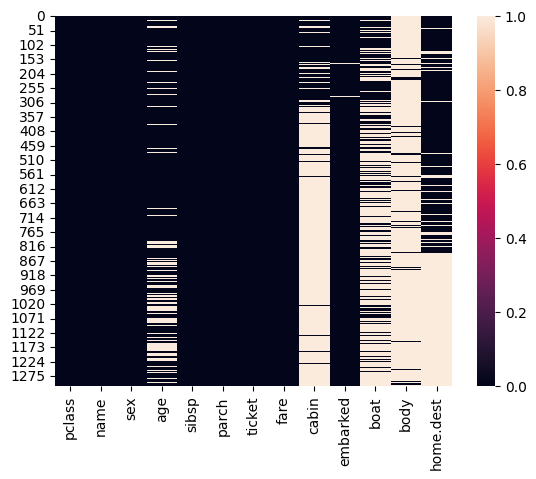

In [10]:
sns.heatmap(X.isna());

In [11]:
def prepare_df(X):
    return (
        X
        .assign(
            sex_code=lambda d: d.sex.cat.codes,
            embarked_code=lambda d: d.embarked.cat.codes,
        )
        .assign(
            fare=lambda d: d.fare.fillna(method='ffill'),
            age=lambda d: d.age.fillna(method='ffill'),
        )
        .drop(['name', 'sex', 'embarked', 'cabin', 'ticket', 'boat', 'home.dest', 'body'], axis=1)
    )

In [12]:
lr = linear_model.LogisticRegression(max_iter=1_000)

In [13]:
df = prepare_df(X)

In [14]:
lr.fit(df, y)

LogisticRegression(max_iter=1000)

In [15]:
lr.score(df, y)

0.7891520244461421

In [16]:
accuracy_score(y, lr.predict(df))

0.7891520244461421

In [17]:
confusion_matrix(y, lr.predict(df))

array([[689, 120],
       [156, 344]])

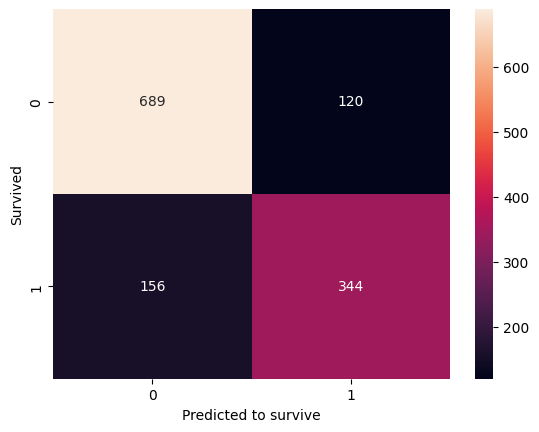

In [18]:
sns.heatmap(confusion_matrix(y, lr.predict(df)), annot=True, fmt="d")
plt.ylabel("Survived")
plt.xlabel("Predicted to survive")
plt.show()

In [19]:
y.value_counts()

survived
0    809
1    500
Name: count, dtype: int64

## Try with a Decision Tree

In [20]:
dt = tree.DecisionTreeClassifier()

In [21]:
dt.fit(df, y)

DecisionTreeClassifier()

In [22]:
dt.score(df, y)

0.9770817417876242

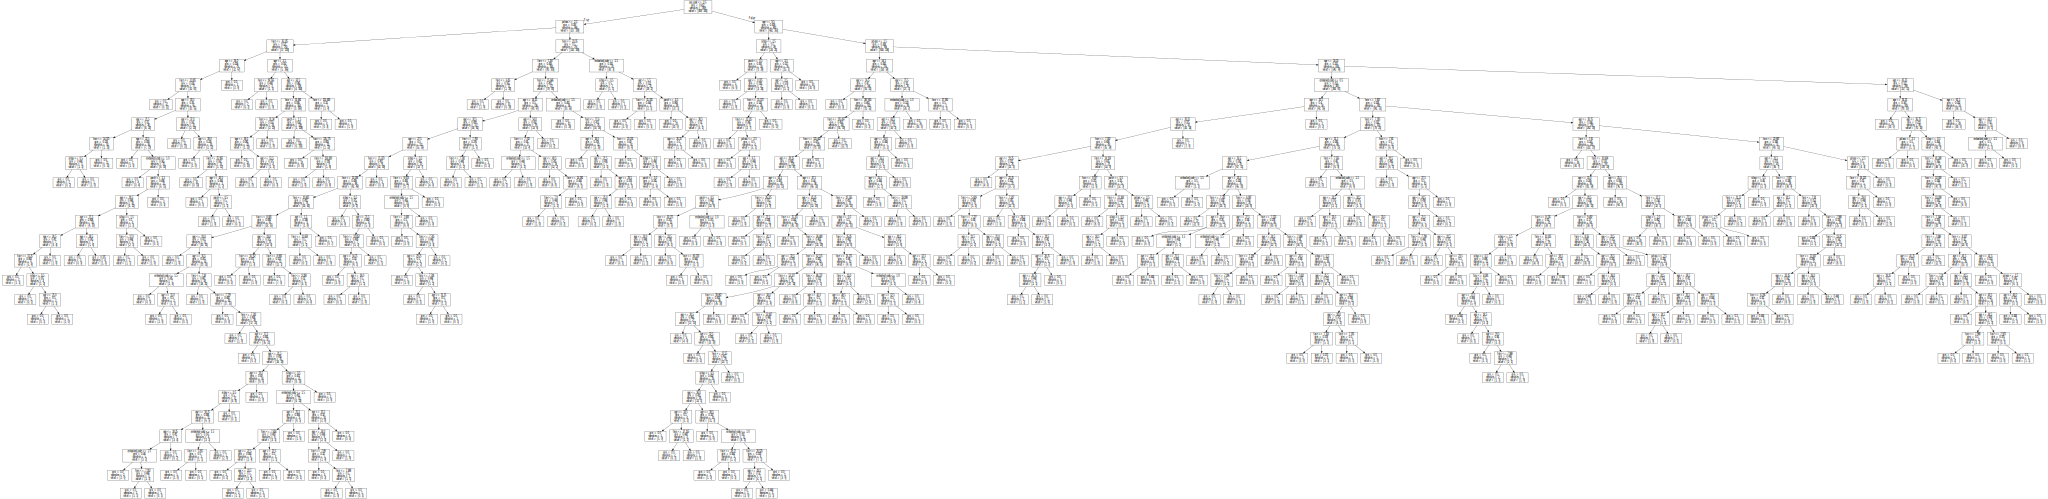

In [23]:
graphviz.Source( tree.export_graphviz(dt, out_file=None, feature_names=df.columns))

In [24]:
model_selection.cross_val_score(dt, df, y)

array([0.5       , 0.79007634, 0.6221374 , 0.64885496, 0.64750958])

In [25]:
model_selection.cross_val_score(dt, df, y).mean()

0.6348395776666373

In [26]:
model_selection.cross_val_score(lr, df, y)

array([0.53053435, 0.83969466, 0.81679389, 0.73282443, 0.68582375])

In [27]:
model_selection.cross_val_score(lr, df, y).mean()

0.7211342166067094

## Decision Tree with regularization (constraint)

In [28]:
dt2 = tree.DecisionTreeClassifier(max_depth=4)

In [29]:
dt2.fit(df, y)

DecisionTreeClassifier(max_depth=4)

In [30]:
model_selection.cross_val_score(dt2, df, y).mean()

0.6752858939487

In [31]:
def plot_feature_importance(lr, df=df):
    summary_lr = (
        pd.DataFrame({
            'coef': lr.coef_[0],
            'feature': df.columns
        })
        .sort_values('coef', ascending=False)
    )

    plt.barh(summary_lr['feature'], summary_lr['coef']);

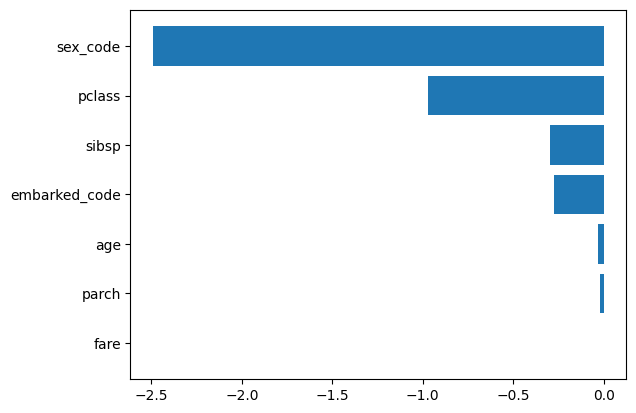

In [32]:
plot_feature_importance(lr)

## Dummay Classifier (choose most frequent answer)

In [33]:
dm = dummy.DummyClassifier()

In [34]:
dm.fit(df, y)

DummyClassifier()

In [35]:
dm.score(df, y)

0.6180290297937356

In [36]:
model_selection.cross_val_score(dm, df, y).mean()

0.6180281360591968

## Introducing Standard Scaler

In [37]:
lr_pipe = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
    linear_model.LogisticRegression(),
)

In [38]:
model_selection.cross_val_score(lr_pipe, df, y).mean()

0.7173174227135796

In [39]:
lr_pipe.fit(df, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

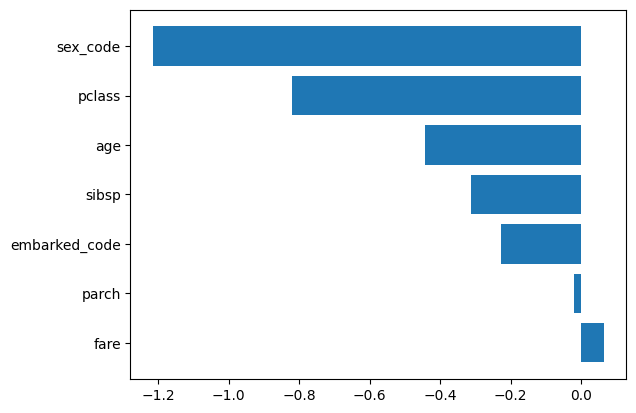

In [40]:
plot_feature_importance(lr_pipe.steps[-1][1])

In [41]:
pd.get_dummies(X, columns=['pclass'])

,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,pclass_1,pclass_2,pclass_3
0,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",True,False,False
1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",True,False,False
2,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",True,False,False
3,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",True,False,False
4,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN,False,False,True
1305,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN,False,False,True
1306,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN,False,False,True
1307,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN,False,False,True


In [42]:
def prepare_df_for_lr(X):
    return (
        pd.get_dummies(X, columns=['embarked'])
        .assign(
            sex_code=lambda d: d.sex.cat.codes,
        #     embarked_code=lambda d: d.embarked.cat.codes,
        )
        .assign(
            fare=lambda d: d.fare.fillna(method='ffill'),
            age=lambda d: d.age.fillna(method='ffill'),
        )
        .drop(['name', 'sex', 'cabin', 'ticket', 'boat', 'home.dest', 'body'], axis=1)
    )

In [43]:
df_for_lr = prepare_df_for_lr(X)

In [44]:
df_for_lr.head()

,pclass,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S,sex_code
0,1,29.0000,0,0,211.3375,False,False,True,0
1,1,0.9167,1,2,151.5500,False,False,True,1
2,1,2.0000,1,2,151.5500,False,False,True,0
3,1,30.0000,1,2,151.5500,False,False,True,1
4,1,25.0000,1,2,151.5500,False,False,True,0


In [45]:
lr2 = linear_model.LogisticRegression(max_iter=1_000)

In [46]:
lr2.fit(df_for_lr, y)

LogisticRegression(max_iter=1000)

In [47]:
model_selection.cross_val_score(lr2, df_for_lr, y).mean()

0.7180690825070926

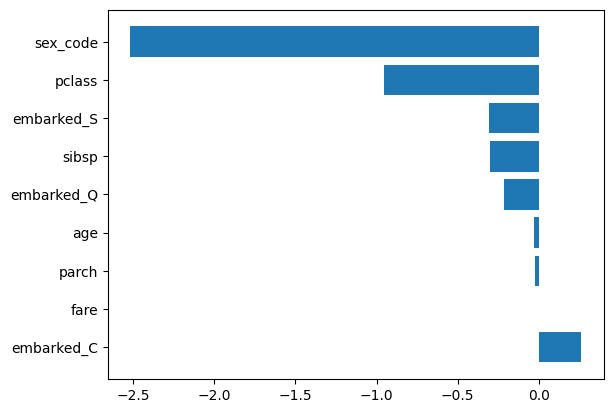

In [48]:
plot_feature_importance(lr2, df=df_for_lr)

## Sigmoid function (part of LogisticRegression)

In [49]:
def sigmoid(x):
    return np.exp(x) / (np.exp(x) + 1)

In [50]:
sigmoid(-2)

0.11920292202211755

In [51]:
sigmoid(2)

0.8807970779778824

In [52]:
sigmoid(-1)

0.2689414213699951

In [53]:
sigmoid(0)

0.5

In [54]:
x = np.linspace(-3, 3)

In [55]:
x

array([-3.        , -2.87755102, -2.75510204, -2.63265306, -2.51020408,
       -2.3877551 , -2.26530612, -2.14285714, -2.02040816, -1.89795918,
       -1.7755102 , -1.65306122, -1.53061224, -1.40816327, -1.28571429,
       -1.16326531, -1.04081633, -0.91836735, -0.79591837, -0.67346939,
       -0.55102041, -0.42857143, -0.30612245, -0.18367347, -0.06122449,
        0.06122449,  0.18367347,  0.30612245,  0.42857143,  0.55102041,
        0.67346939,  0.79591837,  0.91836735,  1.04081633,  1.16326531,
        1.28571429,  1.40816327,  1.53061224,  1.65306122,  1.7755102 ,
        1.89795918,  2.02040816,  2.14285714,  2.26530612,  2.3877551 ,
        2.51020408,  2.63265306,  2.75510204,  2.87755102,  3.        ])

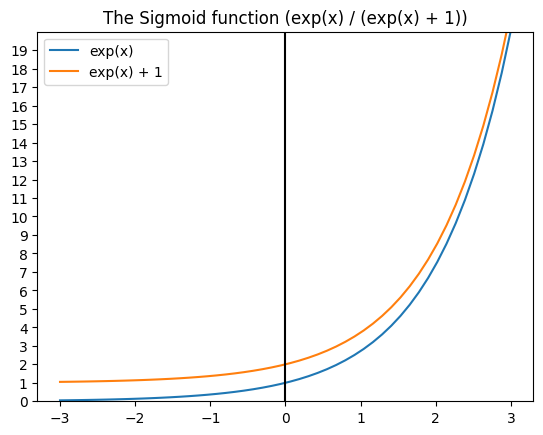

In [56]:
plt.plot(x, np.exp(x), label="exp(x)")
plt.plot(x, np.exp(x) + 1, label="exp(x) + 1")
plt.axvline(0, color='black')
plt.yticks(range(0, 20))
plt.ylim(0, 20)
plt.title("The Sigmoid function (exp(x) / (exp(x) + 1))")
plt.legend();

## Random Forest (multiple Decision Trees)

In [57]:
rf = ensemble.RandomForestClassifier(min_samples_split=20, n_estimators=500)

In [58]:
model_selection.cross_val_score(rf, df, y).mean()

0.6676552309087187

## Using Optuna

In [59]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 40)

    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    
    rf = ensemble.RandomForestClassifier(min_samples_split=min_samples_split, n_estimators=n_estimators, random_state=1, criterion=criterion)

    return model_selection.cross_val_score(rf, df, y).mean()

In [60]:
# mlflc = MLflowCallback(
#     tracking_uri=mlflow.get_tracking_uri(),
#     metric_name="my metric score",
# )

study = optuna.create_study(
    storage="sqlite:///db.sqlite3",
    # study_name="rf_study2",
    direction="maximize"
)

[I 2023-07-25 13:02:21,492] A new study created in RDB with name: no-name-f4555f9c-a061-4de8-bc62-3cd14c8dff0d


In [61]:
study.optimize(objective, n_trials=100) # , callbacks=[mlflc])

[I 2023-07-25 13:02:21,852] Trial 0 finished with value: 0.6783451785557604 and parameters: {'criterion': 'entropy', 'min_samples_split': 36, 'n_estimators': 49}. Best is trial 0 with value: 0.6783451785557604.
[I 2023-07-25 13:02:22,365] Trial 1 finished with value: 0.6814073879090989 and parameters: {'criterion': 'gini', 'min_samples_split': 7, 'n_estimators': 77}. Best is trial 1 with value: 0.6814073879090989.
[I 2023-07-25 13:02:22,942] Trial 2 finished with value: 0.6753005176800913 and parameters: {'criterion': 'log_loss', 'min_samples_split': 28, 'n_estimators': 92}. Best is trial 1 with value: 0.6814073879090989.
[I 2023-07-25 13:02:23,101] Trial 3 finished with value: 0.6669006463689275 and parameters: {'criterion': 'gini', 'min_samples_split': 25, 'n_estimators': 17}. Best is trial 1 with value: 0.6814073879090989.
[I 2023-07-25 13:02:23,372] Trial 4 finished with value: 0.6569857564856247 and parameters: {'criterion': 'log_loss', 'min_samples_split': 4, 'n_estimators': 31}.

In [62]:
#print(mlflow.get_tracking_uri())

In [63]:
study.best_params

{'criterion': 'gini', 'min_samples_split': 32, 'n_estimators': 29}

In [64]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_min_samples_split,params_n_estimators,state
0,0,0.678345,2023-07-25 13:02:21.509754,2023-07-25 13:02:21.838277,0 days 00:00:00.328523,entropy,36,49,COMPLETE
1,1,0.681407,2023-07-25 13:02:21.858423,2023-07-25 13:02:22.353980,0 days 00:00:00.495557,gini,7,77,COMPLETE
2,2,0.675301,2023-07-25 13:02:22.370982,2023-07-25 13:02:22.932259,0 days 00:00:00.561277,log_loss,28,92,COMPLETE
3,3,0.666901,2023-07-25 13:02:22.948351,2023-07-25 13:02:23.090551,0 days 00:00:00.142200,gini,25,17,COMPLETE
4,4,0.656986,2023-07-25 13:02:23.106515,2023-07-25 13:02:23.356259,0 days 00:00:00.249744,log_loss,4,31,COMPLETE
...,...,...,...,...,...,...,...,...,...
95,95,0.695142,2023-07-25 13:02:48.381077,2023-07-25 13:02:48.644004,0 days 00:00:00.262927,gini,35,40,COMPLETE
96,96,0.682946,2023-07-25 13:02:48.659812,2023-07-25 13:02:48.897383,0 days 00:00:00.237571,gini,28,35,COMPLETE
97,97,0.682174,2023-07-25 13:02:48.912897,2023-07-25 13:02:49.114154,0 days 00:00:00.201257,log_loss,36,27,COMPLETE
98,98,0.687517,2023-07-25 13:02:49.130510,2023-07-25 13:02:49.435544,0 days 00:00:00.305034,gini,29,47,COMPLETE


In [65]:
stack_cls = ensemble.StackingClassifier([('lr', lr), ('rf', rf)], linear_model.LogisticRegression(max_iter=1_000))

In [66]:
stack_cls

StackingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                               ('rf',
                                RandomForestClassifier(min_samples_split=20,
                                                       n_estimators=500))],
                   final_estimator=LogisticRegression(max_iter=1000))

In [67]:
model_selection.cross_val_score(stack_cls, df, y).mean()

0.7631569711327543

In [68]:
X

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN


In [69]:
(
    X
    .assign(
        in_family=lambda d: d.sibsp + d.parch > 0
    )
)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,in_family
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",False
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",True
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",True
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",True
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN,True
1305,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN,True
1306,3,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN,False
1307,3,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN,False


In [70]:
import re

In [71]:
name = "hello Mr. Yossi"

In [72]:
get_title = re.compile(r'\s(\w+)\.\s')

In [73]:
m = get_title.search(name)

In [74]:
m

<re.Match object; span=(5, 10), match=' Mr. '>

In [75]:
m[1]

'Mr'

In [76]:
(
    X
    .assign(
        title=lambda d: d.name.str.extract(get_title)
    )
)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,title
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",Miss
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",Master
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",Miss
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",Mr
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",Mrs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN,Miss
1305,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN,Miss
1306,3,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN,Mr
1307,3,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN,Mr


In [78]:
ohe = OneHotEncoder(handle_unknown='infrequent_if_exist')

In [79]:
ohe.fit((
    X
    .assign(
        title=lambda d: d.name.str.extract(get_title)
    )
)[['title']])

OneHotEncoder(handle_unknown='infrequent_if_exist')

In [80]:
ohe.categories_

[array(['Capt', 'Col', 'Countess', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady',
        'Major', 'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev',
        'Sir'], dtype=object)]

In [84]:
ohe.transform(pd.DataFrame([['Capt']], columns=["title"])).todense()

matrix([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

In [85]:
ohe.inverse_transform([[0, 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

array([['Col']], dtype=object)

In [159]:
def prepare_df_for_pipe1(X):
    return (
        X
        .assign(
            sex_code=lambda d: d.sex.cat.codes,
            title=lambda d: d.name.str.extract(get_title),
            fare=lambda d: d.fare.fillna(method='ffill'),
            age=lambda d: d.age.fillna(method='ffill'),
            in_family=lambda d: d.sibsp + d.parch > 0,
        )
        .drop(['sex', 'cabin', 'ticket', 'boat', 'home.dest', 'body'], axis=1) #  'sibsp', 'parch'
     )

In [160]:
df_for_pipe1 = prepare_df_for_pipe1(X)

In [161]:
pipe1 = pipeline.make_pipeline(
    ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['title', 'embarked']),
        ('name', "drop", ['name']),
    ], remainder='passthrough'),
    linear_model.LogisticRegression(max_iter=1_000),
)

In [162]:
pipe1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['title', 'embarked']),
                                                 ('name', 'drop', ['name'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [163]:
pipe1.fit(df_for_pipe1, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['title', 'embarked']),
                                                 ('name', 'drop', ['name'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [164]:
model_selection.cross_val_score(pipe1, df_for_pipe1, y).mean()

0.7318300137463075

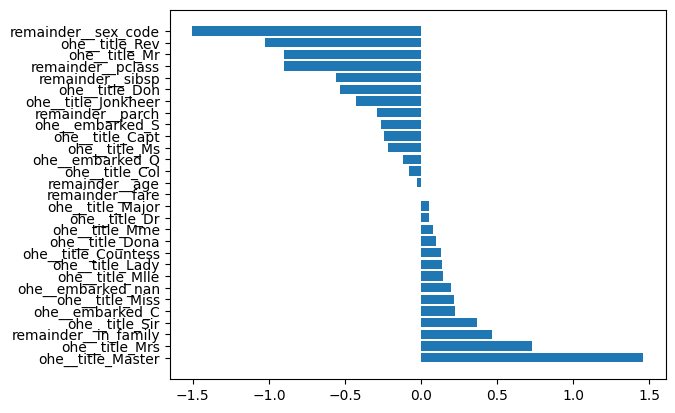

In [165]:
plot_feature_importance(
    pipe1.steps[-1][1],
    df=pd.DataFrame(
        pipe1.steps[0][1].transform(df_for_pipe1),
        columns=pipe1.steps[0][1].get_feature_names_out(),
    )
)